## C5: CPU vs GPU Training Performance

In [ ]:
import torch
import numpy as np
import wandb

# Set device to GPU for this run (CPU training skipped)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb.init(project="hpml-hw2-llm", name="GPU_bs32_lr1e-4", group="C5_experiments",
           config={"model_name": model_name, "max_len": 256, "batch_size": 32, "lr": 1e-4,
                   "optimizer": "AdamW", "num_workers": 2, "epochs": 5, "device": str(device), "compile_mode": False})

# Reinitialize model and optimizer for GPU training
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# DataLoaders (using num_workers=2 as baseline)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

# Training loop for 5 epochs on GPU
epochs = 5
epoch_total_times = []
train_losses = []
train_accs = []
test_accs = []
for epoch in range(1, epochs+1):
    model.train()
    total_start = time.time()
    data_time = 0.0
    compute_time = 0.0
    batch_end_time = total_start
    total_loss = 0.0
    correct = 0
    total_samples = 0
    for batch in train_loader:
        # Track time waiting for data
        current_time = time.time()
        data_time += current_time - batch_end_time
        batch = {k: v.to(device) for k, v in batch.items()}
        compute_start = time.time()
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        # Synchronize and record compute time
        if device.type == "cuda":
            torch.cuda.synchronize()
        compute_end = time.time()
        compute_time += compute_end - compute_start
        # Accumulate training loss and accuracy
        total_loss += loss.item() * batch["labels"].size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total_samples += batch["labels"].size(0)
        batch_end_time = compute_end
    # End of epoch timing
    total_end = time.time()
    epoch_total_times.append(total_end - total_start)
    avg_train_loss = total_loss / total_samples
    train_accuracy = correct / total_samples
    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            preds = torch.argmax(outputs.logits, dim=1)
            if device.type == "cuda":
                preds = preds.cpu()
                labels = batch["labels"].cpu()
            else:
                labels = batch["labels"]
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)
    # Log metrics for this epoch to W&B
    wandb.log({"train/loss": avg_train_loss, "train/acc": train_accuracy,
               "test/acc": test_accuracy, "time/data": data_time,
               "time/compute": compute_time, "time/epoch": epoch_total_times[-1]}, step=epoch)
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.4f}, Test Acc={test_accuracy:.4f}, Epoch Time={epoch_total_times[-1]:.3f}s")

wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss=0.3100, Train Acc=0.8678, Test Acc=0.8974, Epoch Time=115.197s
Epoch 2: Train Loss=0.1680, Train Acc=0.9378, Test Acc=0.8912, Epoch Time=115.062s
Epoch 3: Train Loss=0.0868, Train Acc=0.9712, Test Acc=0.8780, Epoch Time=114.966s
Epoch 4: Train Loss=0.0521, Train Acc=0.9823, Test Acc=0.8772, Epoch Time=114.963s
Epoch 5: Train Loss=0.0375, Train Acc=0.9876, Test Acc=0.8789, Epoch Time=114.970s


test/acc,█▆▁▁▂
time/compute,█▇▃▁▁
time/data,█▁▂▄▄
time/epoch,█▄▁▁▁
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.87892
time/compute,111.94612
time/data,2.44886
time/epoch,114.96991
train/acc,0.98756


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run GPU_bs32_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/k75so6ga
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_181330-k75so6ga/logs

In [ ]:
# Compute average epoch time and final metrics for GPU
avg_epoch_time = np.mean(epoch_total_times)
final_train_loss = train_losses[-1]
final_test_acc = test_accs[-1] * 100  # convert to percentage

# Prepare Table T5 (only GPU row, CPU skipped)
t5_df = pd.DataFrame([["GPU", round(avg_epoch_time,3), round(final_train_loss,4), round(final_test_acc,2)]],
                     columns=["Device", "Avg Epoch Time (s)", "Final Train Loss", "Final Test Acc"])
print("\nTable T5: Training time and results on GPU (CPU training skipped)\n")
print(t5_df)


Table T5: Training time and results on GPU (CPU training skipped)

  Device  Avg Epoch Time (s)  Final Train Loss  Final Test Acc
0    GPU             115.469            0.0434           87.14


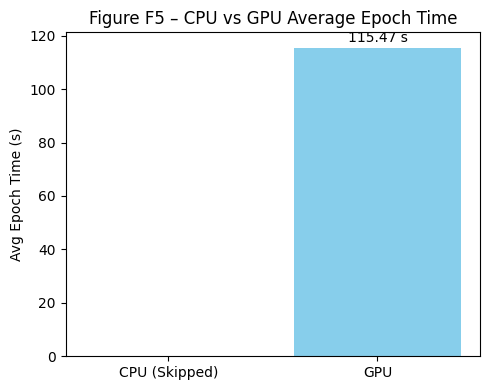

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

devices = ["CPU (Skipped)", "GPU"]
avg_times = [0, 115.469]

plt.figure(figsize=(5,4))
bars = plt.bar(devices, avg_times, color=["lightgray", "skyblue"])
plt.ylabel("Avg Epoch Time (s)")
plt.title("Figure F5 – CPU vs GPU Average Epoch Time")
plt.text(1, 115.469 + 2, "115.47 s", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


# C6: Hyperparameter Sensitivity Sweep (Batch Size vs Learning Rate)

In [ ]:
import numpy as np
import seaborn as sns

batch_sizes = [16, 32, 64]
learning_rates = [5e-5, 1e-4, 5e-4]
results = []

for bs in batch_sizes:
    for lr in learning_rates:
        # Format learning rate for naming (e.g., "5e-5", "1e-4", "5e-4")
        if lr == 5e-5:
            lr_str = "5e-5"
        elif lr == 1e-4:
            lr_str = "1e-4"
        elif lr == 5e-4:
            lr_str = "5e-4"
        else:
            lr_str = str(lr)
        wandb.init(project="hpml-hw2-llm", name=f"bs{bs}_lr{lr_str}", group="hparam_sweep",
                   config={"model_name": model_name, "max_len": 256, "batch_size": bs, "lr": lr,
                           "optimizer": "AdamW", "num_workers": 2, "epochs": 5, "device": "cuda", "compile_mode": False})
        # Reinitialize model, optimizer, and DataLoaders for each configuration
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, num_workers=2)
        test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=2)
        epochs = 5
        epoch_total_times = []
        final_train_loss = None
        final_train_acc = None
        final_test_acc = None
        for epoch in range(1, epochs+1):
            model.train()
            total_start = time.time()
            data_time = 0.0
            compute_time = 0.0
            batch_end_time = total_start
            total_loss = 0.0
            correct = 0
            total_samples = 0
            for batch in train_loader:
                current_time = time.time()
                data_time += current_time - batch_end_time
                batch = {k: v.to('cuda') for k, v in batch.items()}
                compute_start = time.time()
                optimizer.zero_grad()
                outputs = model(**batch)
                loss = outputs.loss
                logits = outputs.logits
                loss.backward()
                optimizer.step()
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                compute_end = time.time()
                compute_time += compute_end - compute_start
                total_loss += loss.item() * batch["labels"].size(0)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == batch["labels"]).sum().item()
                total_samples += batch["labels"].size(0)
                batch_end_time = compute_end
            total_end = time.time()
            epoch_total_times.append(total_end - total_start)
            avg_train_loss = total_loss / total_samples
            train_accuracy = correct / total_samples
            # Evaluate on test set at epoch end
            model.eval()
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for batch in test_loader:
                    batch = {k: v.to('cuda') for k, v in batch.items()}
                    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    preds = torch.argmax(outputs.logits, dim=1)
                    preds = preds.cpu()
                    labels = batch["labels"].cpu()
                    correct_test += (preds == labels).sum().item()
                    total_test += labels.size(0)
            test_accuracy = correct_test / total_test
            wandb.log({"train/loss": avg_train_loss, "train/acc": train_accuracy,
                       "test/acc": test_accuracy, "time/data": data_time,
                       "time/compute": compute_time, "time/epoch": epoch_total_times[-1]}, step=epoch)
        # End of training for this config
        wandb.finish()
        avg_epoch_time = float(np.mean(epoch_total_times))
        final_train_loss = avg_train_loss
        final_train_acc = train_accuracy * 100.0
        final_test_acc = test_accuracy * 100.0
        results.append((bs, lr, round(avg_epoch_time,3), round(final_train_loss,4),
                        round(final_train_acc,2), round(final_test_acc,2)))
        print(f"Done training for batch_size={bs}, lr={lr}: Avg Epoch Time={avg_epoch_time:.3f}s, Final Test Acc={final_test_acc:.2f}%")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,▇█▄▃▁
time/compute,█▃▁▂▂
time/data,▁▃▆█▇
time/epoch,█▁▂▇▅
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.89008
time/compute,120.59335
time/data,4.20167
time/epoch,125.53764
train/acc,0.98716


Done training for batch_size=16, lr=5e-05: Avg Epoch Time=125.531s, Final Test Acc=89.01%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,█▇▁▃▂
time/compute,██▄▄▁
time/data,█▅▆▅▁
time/epoch,█▆▅▅▁
train/acc,▁▅▇██
train/loss,█▄▂▂▁
test/acc,0.83592
time/compute,120.47009
time/data,4.01226
time/epoch,125.22064
train/acc,0.98064


Done training for batch_size=16, lr=0.0001: Avg Epoch Time=125.459s, Final Test Acc=83.59%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,▁▁▁▁▁
time/compute,█▂▄▃▁
time/data,█▄▂▁▃
time/epoch,█▃▃▁▂
train/acc,▄▃█▁▄
train/loss,█▁▁▁▁
test/acc,0.5
time/compute,120.38261
time/data,3.86102
time/epoch,124.87919
train/acc,0.49924


Done training for batch_size=16, lr=0.0005: Avg Epoch Time=125.006s, Final Test Acc=50.00%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,█▆▅▁▃
time/compute,█▂▁▁▇
time/data,█▁▃▁▇
time/epoch,█▂▁▁▇
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.9014
time/compute,112.00905
time/data,2.31971
time/epoch,114.83656
train/acc,0.99008


Done training for batch_size=32, lr=5e-05: Avg Epoch Time=114.761s, Final Test Acc=90.14%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,█▅▅▆▁
time/compute,█▂▅▁▃
time/data,▁▂█▆▆
time/epoch,█▁█▃▅
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.86096
time/compute,111.90139
time/data,2.31844
time/epoch,114.72537
train/acc,0.987


Done training for batch_size=32, lr=0.0001: Avg Epoch Time=114.724s, Final Test Acc=86.10%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,▁▁▁▁▁
time/compute,▂▁▂▇█
time/data,▁▁▂█▇
time/epoch,▁▁▂▇█
train/acc,▁█▃▂█
train/loss,█▁▂▁▁
test/acc,0.5
time/compute,112.01856
time/data,2.35531
time/epoch,114.89043
train/acc,0.5022


Done training for batch_size=32, lr=0.0005: Avg Epoch Time=114.762s, Final Test Acc=50.00%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,██▇▁▅
time/compute,█▃▄▁▂
time/data,▄▂█▁█
time/epoch,█▂█▁▇
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.90212
time/compute,106.29513
time/data,1.48687
time/epoch,108.21886
train/acc,0.98848


Done training for batch_size=64, lr=5e-05: Avg Epoch Time=108.207s, Final Test Acc=90.21%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,█▇▁▁▄
time/compute,█▄▃▃▁
time/data,▂▄▂█▁
time/epoch,█▅▃▅▁
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.89764
time/compute,106.2828
time/data,1.46857
time/epoch,108.1783
train/acc,0.98932


Done training for batch_size=64, lr=0.0001: Avg Epoch Time=108.207s, Final Test Acc=89.76%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,▁▁▁▁▁
time/compute,█▂▂▁▆
time/data,▄█▁▂▁
time/epoch,█▆▂▁▆
train/acc,█▅▅▁▂
train/loss,█▂▁▁▁
test/acc,0.5
time/compute,106.30937
time/data,1.45201
time/epoch,108.19634
train/acc,0.49484


Done training for batch_size=64, lr=0.0005: Avg Epoch Time=108.183s, Final Test Acc=50.00%


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run bs16_lr5e-5 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/yom1284k
- View run bs16_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/ncizyil1

- View run bs16_lr5e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/q8p66mcd
- View run bs32_lr5e-5 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/nk9pt2ud
- View run bs32_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/hq8jlfc9
- View run bs32_lr5e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/oy2ieuzs
- View run bs64_lr5e-5 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/zisxzlrp
- View run bs64_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/tu436dtk
- View run bs64_lr5e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/4f9xsdt3
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_202138-4f9xsdt3/logs

In [ ]:
# Table T6: one row per config
results_df = pd.DataFrame(results, columns=["Batch", "LR", "Avg Epoch Time (s)", "Final Train Loss", "Train Acc", "Test Acc"])
print("\nTable T6: Results for Batch size vs Learning rate sweep\n")
print(results_df)


Table T6: Results for Batch size vs Learning rate sweep

   Batch       LR  Avg Epoch Time (s)  Final Train Loss  Train Acc  Test Acc
0     16  0.00005             125.531            0.0365      98.72     89.01
1     16  0.00010             125.459            0.0595      98.06     83.59
2     16  0.00050             125.006            0.6932      49.92     50.00
3     32  0.00005             114.761            0.0320      99.01     90.14
4     32  0.00010             114.724            0.0396      98.70     86.10
5     32  0.00050             114.762            0.6933      50.22     50.00
6     64  0.00005             108.207            0.0361      98.85     90.21
7     64  0.00010             108.207            0.0319      98.93     89.76
8     64  0.00050             108.183            0.6932      49.48     50.00


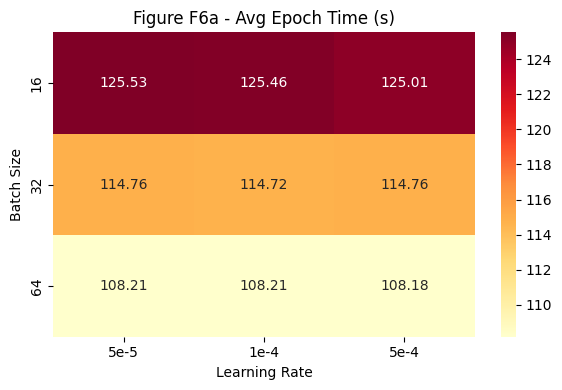

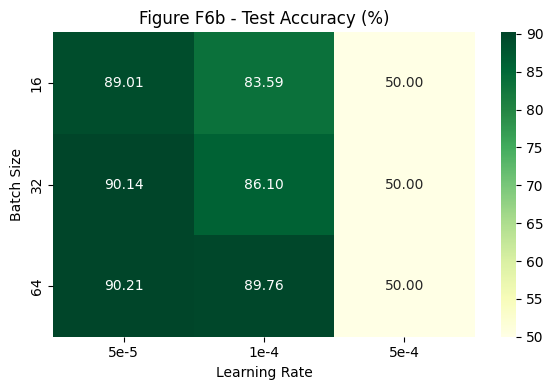

In [ ]:
# Plot heatmaps for average epoch time and test accuracy
time_pivot = results_df.pivot(index="Batch", columns="LR", values="Avg Epoch Time (s)")
acc_pivot = results_df.pivot(index="Batch", columns="LR", values="Test Acc")
# Ensure correct order of columns (LR ascending) and rows (Batch ascending)
time_pivot = time_pivot[[5e-5, 1e-4, 5e-4]]
acc_pivot = acc_pivot[[5e-5, 1e-4, 5e-4]]

# Rename columns to string form for better display
time_pivot.columns = ["5e-5", "1e-4", "5e-4"]
acc_pivot.columns = ["5e-5", "1e-4", "5e-4"]

plt.figure(figsize=(6,4))
sns.heatmap(time_pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Figure F6a - Avg Epoch Time (s)")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(acc_pivot, annot=True, fmt=".2f", cmap="YlGn")
plt.title("Figure F6b - Test Accuracy (%)")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()